In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import h5py
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from tqdm import tqdm
from paras import ng, h
from mass_assign import *
from grav_potential import *
from acceleration import *

# cosmo = FlatLambdaCDM(H0=50, Om0=1)

In [2]:
# https://web.archive.org/web/20130217114132/http://t8web.lanl.gov/people/heitmann/test3.html
filename = '/Users/abry/data/Santa_Barbara/ic_sb128/particles_ic_sb128'
data = np.fromfile(filename, dtype=np.float32)
data = data.reshape(-1, 8)
par_df = pd.DataFrame(columns=['pos_x','vel_x','pos_y','vel_y','pos_z','vel_z','mass','id'], data=data)
# x[Mpc], v_x[km/s], y[Mpc], v_y[km/s], z[Mpc], v_z[km/s], particle mass[M_sol], particle tag
par_df.loc[:, ['vel_x','vel_y', 'vel_z']] = par_df.loc[:, ['vel_x','vel_y', 'vel_z']]*(u.km/u.s).to(u.Mpc/u.Gyr)
par_df.loc[:, ['pos_x','vel_x','pos_y','vel_y','pos_z','vel_z','mass']] = par_df.loc[:, ['pos_x','vel_x','pos_y','vel_y','pos_z','vel_z','mass']]*(ng/64)

In [4]:
len(par_df)

2097152

Particle position

(0.0, 128.0)

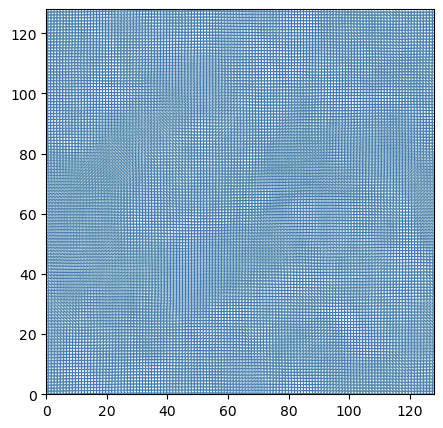

In [8]:
pars_info = par_df.loc[:,['pos_x', 'pos_y', 'pos_z', 'vel_x', 'vel_y', 'vel_z', 'mass']].values
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(pars_info[:, 0], pars_info[:, 1], s=0.0001,)
ax.set_ylim(0, ng)
ax.set_xlim(0, ng)

Initial projected density

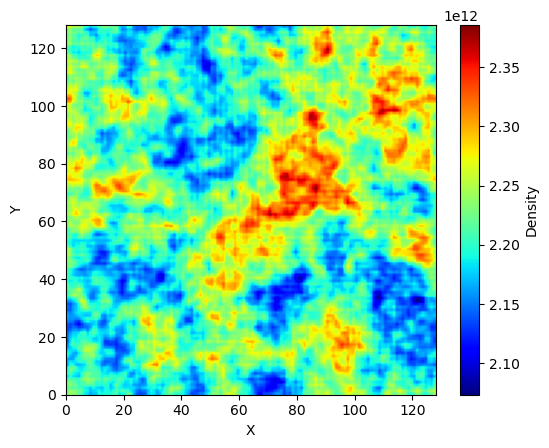

In [9]:
dens = cic_density_3d(pars_info[:,[0,1,2,6]])
# Project density field along z-axis
dens_proj0 = np.sum(dens, axis=2)

# Visualize projected density field using Matplotlib
fig, ax = plt.subplots()
im = ax.imshow(dens_proj0.T, cmap='jet',origin='lower', extent=[0, ng, 0, ng])
ax.set_xlabel('X')
ax.set_ylabel('Y')
cbar = fig.colorbar(im)
cbar.set_label('Density')
plt.show()

In [5]:
# Preparing frames
frames = []
step_num = 120
dt = 0.02
for step in tqdm(range(step_num)):

    pars_info[:, 0:3] = (pars_info[:, 0:3] + pars_info[:, 3:6] * 0.5 * dt) % ng # Fitrst step with Periodic boundary condition:

    dens = cic_density_3d(pars_info[:,[0,1,2,6]])
    phi = grav_phi_3d(dens)
    acc_mesh_x, acc_mesh_y, acc_mesh_z = acc_mesh_3d(phi)
    acc_par_x, acc_par_y, acc_par_z = acc_par_3d(pars_info[:,[0,1,2]], acc_mesh_x, acc_mesh_y, acc_mesh_z)

    pars_info[:, 3:6] += np.array([acc_par_x, acc_par_y, acc_par_z]).T * dt # Second step:

    pars_info[:, 0:3] = (pars_info[:, 0:3] + pars_info[:, 3:6] * 0.5 * dt) % ng # Third step with Periodic boundary condition:

    frames.append(np.sum(cic_density_3d(pars_info[:,[0,1,2,6]]), axis=2).T) # dens_proj

with h5py.File('dens_proj.hdf5', 'w') as f:
    f.create_dataset('dens_proj', data=np.array(frames))

100%|██████████| 120/120 [3:06:18<00:00, 93.16s/it] 


In [6]:
with h5py.File('dens_proj.hdf5', 'r') as f:
    print(list(f.keys()))
    frames = f['dens_proj'][:]

['dens_proj']


Make movie

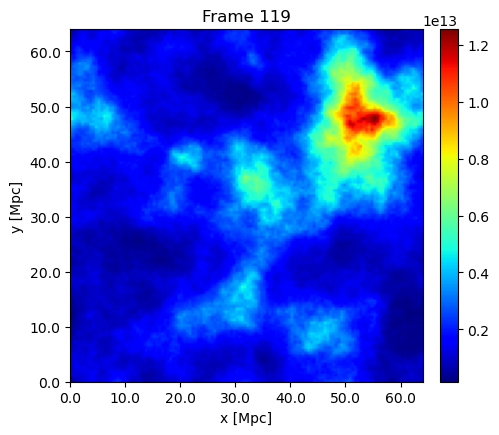

In [6]:

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_ylim(0, ng)
ax.set_xlim(0, ng)
ax.set_xlabel('x [Mpc]')
ax.set_ylabel('y [Mpc]')
ax.set_xticks(np.arange(0, ng, 20))
ax.set_yticks(np.arange(0, ng, 20))
ax.set_xticklabels(np.arange(0, ng/2, 10))
ax.set_yticklabels(np.arange(0, ng/2, 10))

# I like to position my colorbars this way, but you don't have to
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')
cv0 = frames[0]
im = ax.imshow(cv0, origin='lower',cmap='jet', extent=[0, ng, 0, ng],) # Here make an AxesImage rather than contour
cb = fig.colorbar(im, cax=cax)
tx = ax.set_title('Frame 0')
def animate(i):
    arr = frames[i]
    vmax     = np.max(arr)
    vmin     = np.min(arr)
    im.set_data(arr)
    im.set_clim(vmin, vmax)
    tx.set_text('Frame {0}'.format(i))
ani = animation.FuncAnimation(fig, animate, frames=step_num,)
ani.save('movie.mp4')
plt.show()

Figure in the paper

In [23]:
import matplotlib as mpl
plt.style.use(["classic"])

mpl.rc( 'lines', linewidth=3 )
mpl.rc( 'font', family='monospace', weight='normal', size=20 )

c_frame = (0,0,0,.8)
for tick in 'xtick', 'ytick':
    mpl.rc( tick+'.major', width=1.5, size=8)
    mpl.rc( tick+'.minor', width=1, size=4, visible=True )
    mpl.rc( tick, color=c_frame, labelsize=18, direction='in' )
mpl.rc( 'xtick', top=True )
mpl.rc( 'ytick', right=True )
mpl.rc( 'axes', linewidth=1.5, edgecolor=c_frame, labelweight='normal' )
mpl.rc( 'grid', color=c_frame)
mpl.rc( 'patch', edgecolor=c_frame)

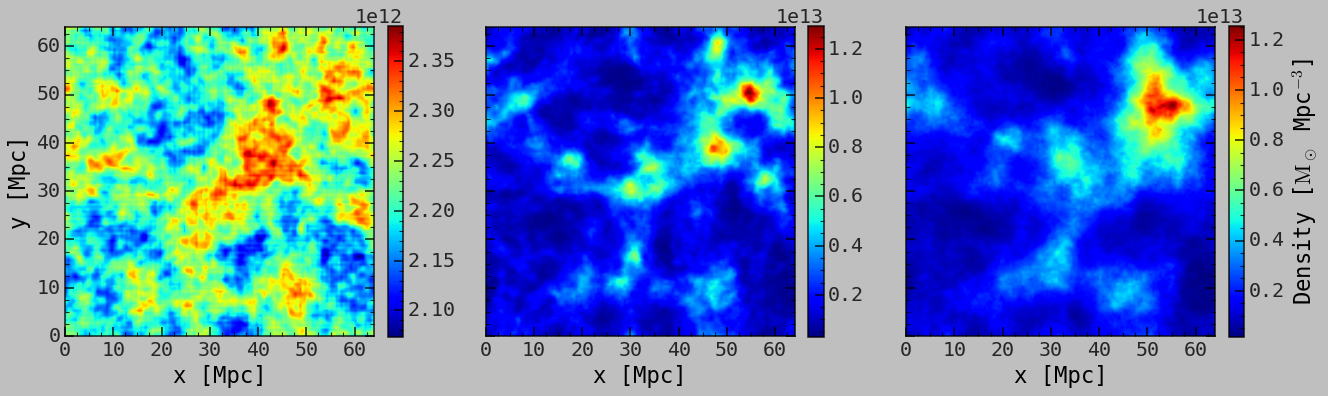

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5),height_ratios=[1])
ax1, ax2, ax3 = axes.flatten()
im1 = ax1.imshow(dens_proj0.T, cmap='jet',origin='lower', extent=[0, ng, 0, ng])
im2 = ax2.imshow(frames[75], cmap='jet',origin='lower', extent=[0, ng, 0, ng])
im3 = ax3.imshow(frames[-1], cmap='jet',origin='lower', extent=[0, ng, 0, ng])
cb1 = fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
cb2 = fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
cb3 = fig.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)
cb3.set_label(r'Density [$\rm M_\odot$ Mpc$^{-3}$]')
for ax in axes.flatten():
    ax.set_xlabel('x [Mpc]')
    ax.set_xticks(np.arange(0, ng, 20))
    ax.set_yticks(np.arange(0, ng, 20))
    ax.set_xticklabels(np.arange(0, ng/2, 10).astype(int))
    ax.set_yticklabels(np.arange(0, ng/2, 10).astype(int))
    ax.label_outer()
ax1.set_ylabel('y [Mpc]')
ax2.set_yticklabels([]);
ax3.set_yticklabels([]);
fig.tight_layout()
plt.savefig('density_field.pdf', bbox_inches='tight')